In [4]:
%matplotlib inline

import os
# Hide welcome message from bitsandbytes
os.environ.update({"BITSANDBYTES_NOWELCOME": "1"})

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision import transforms
from lib.sgm import AutoencoderKL
from lib.utils import load_torch_file, load_model_weights
from pathlib import Path    
from omegaconf import OmegaConf

yaml_file = Path("lib/model_configs/sd_xl_base.yaml")
model_params = OmegaConf.load(yaml_file).model.params        
first_stage_model = AutoencoderKL(**model_params.first_stage_config.params)
state_dict = load_torch_file("/notebooks/ComfyUI/models/checkpoints/sd_xl_base_1.0_0.9vae.safetensors")

class WeightsLoader(torch.nn.Module):
    pass
        
w = WeightsLoader()
w.first_stage_model = first_stage_model
_ = load_model_weights(w, state_dict)


Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


Creating index: 0it [00:00, ?it/s]

stat: 0.30244457721710205, 1.090697169303894


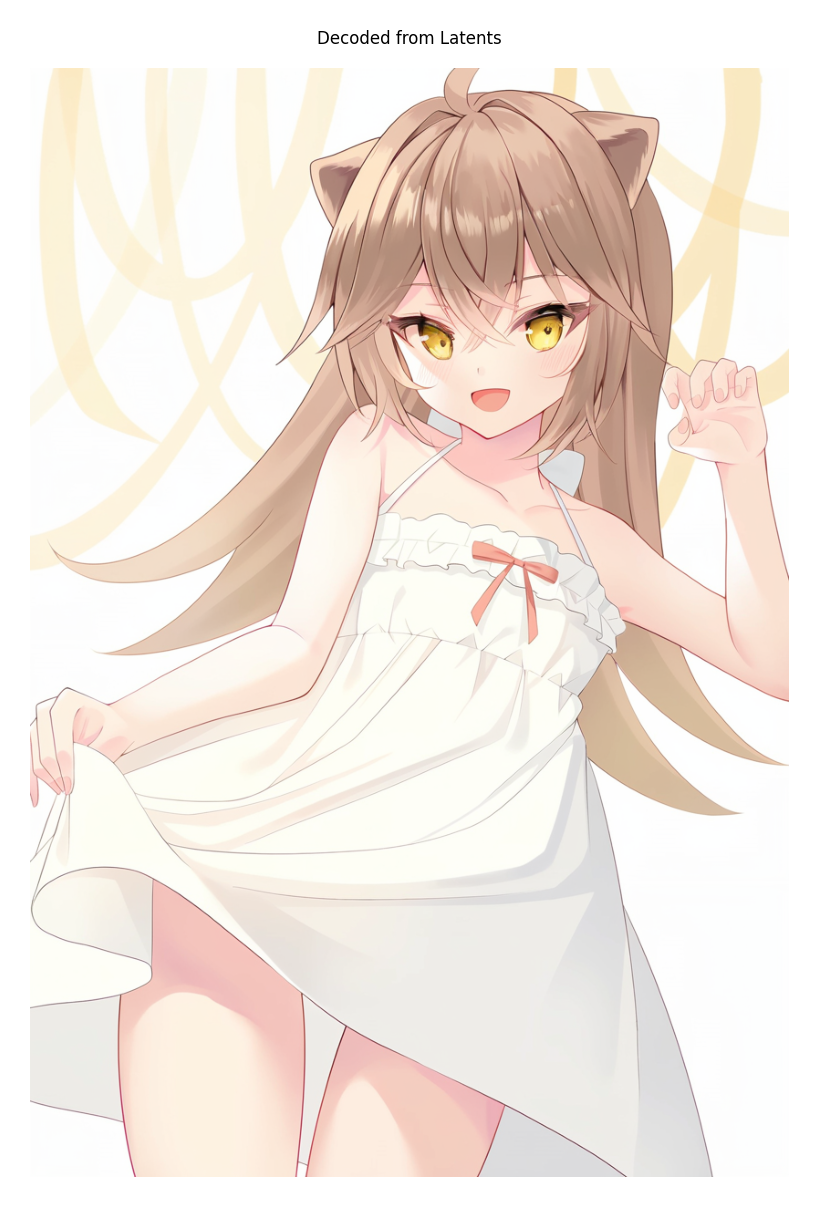

In [72]:
import h5py, random
from tqdm.notebook import tqdm

def denormalize(img, mean=0.5, std=0.5):
    res = transforms.Normalize((-1*mean/std), (1.0/std))(img)
    res = torch.clamp(res, 0, 1)
    return res

def create_vds_for_group(source_group, target_group, bar):
    for key, item in source_group.items():
        if key in target_group:
            if key.endswith(".latents"):
                bar.update(1)
            continue
        layout = h5py.VirtualLayout(shape=item.shape, dtype=item.dtype)
        layout[:] = h5py.VirtualSource(item)
        target_group.create_virtual_dataset(key, layout)
        if key.endswith(".latents"):
            bar.update(1)

# Load latents from the h5 file
def load_latents_from_h5(h5_path):
    cache_parts = list(Path(h5_path).glob("cache*.h5"))
    with h5py.File("cache_index.tmp", 'a', libver='latest', driver='core') as fo:  # using 'latest' for VDS support
        bar = tqdm(desc="Creating index")
        for input_file in cache_parts:
            with h5py.File(input_file, 'r') as fi:
                create_vds_for_group(fi, fo, bar)
                
    with h5py.File("cache_index.tmp", 'r') as f:
        # Get all datasets keys that match the pattern
        keys = [key for key in f.keys() if key.endswith(".latents")]
        chosen_key = random.choice(keys)
        latents = f[chosen_key][:]
        return torch.asarray(latents).cuda().to(torch.float32)

# Define path to h5 file containing latents
h5_path = "/notebooks/naifu-diffusion-sgm/cache"
latents = load_latents_from_h5(h5_path)

# Load the model
vae = first_stage_model
vae.eval().cuda()
vae.training = False

# Decode latents
print(f"stat: {latents.mean()}, {latents.std()}")
latents = latents.unsqueeze(0)
latents = 1.0 / 0.13025 * latents
with torch.no_grad():
    img_decoded = vae.decode(latents)

# Convert tensors to numpy arrays for visualization
img_decoded = denormalize(img_decoded).squeeze().permute(1, 2, 0).cpu().numpy()

# Display the decoded image
plt.figure(dpi=300)
plt.imshow(img_decoded)
plt.axis('off')  # turn off the axis
plt.title('Decoded from Latents', fontsize=4)
plt.show()
